# Library imports

In [1]:
import pandas as pd

import matplotlib.ticker as tick
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
from util.reformat_large_tick_values import reformat_large_tick_values as ticker

from sqlalchemy.engine import create_engine
import warnings
warnings.filterwarnings('ignore', message='Cannot create BigQuery Storage client*')

In [2]:
engine = create_engine('bigquery://', credentials_path= 'key/iowa-liquor-sales-365322-12ff7a5498e6.json')

In [3]:
sns.set(font_scale = 1.4)
colors = ['#edc948', '#59a14f', '#ff9da7', '#76b7b2', '#4e79a7', '#b07aa1', '#bab0ac', '#9c755f', '#e15759', '#f28e2b']
county_colors = sns.color_palette(colors)
sns.color_palette(county_colors)

[(0.9294117647058824, 0.788235294117647, 0.2823529411764706),
 (0.34901960784313724, 0.6313725490196078, 0.30980392156862746),
 (1.0, 0.615686274509804, 0.6549019607843137),
 (0.4627450980392157, 0.7176470588235294, 0.6980392156862745),
 (0.3058823529411765, 0.4745098039215686, 0.6549019607843137),
 (0.6901960784313725, 0.47843137254901963, 0.6313725490196078),
 (0.7294117647058823, 0.6901960784313725, 0.6745098039215687),
 (0.611764705882353, 0.4588235294117647, 0.37254901960784315),
 (0.8823529411764706, 0.3411764705882353, 0.34901960784313724),
 (0.9490196078431372, 0.5568627450980392, 0.16862745098039217)]

In [4]:
counties = ['Polk', 'Linn', 'Scott', 'Johnson', 'Black Hawk', 'Woodbury', 'Dubuque', 'Story', 'Dallas', 'Pottawattamie']

In [5]:
county_colors = {county: color for county, color in zip(counties, colors)}
county_colors

{'Polk': '#edc948',
 'Linn': '#59a14f',
 'Scott': '#ff9da7',
 'Johnson': '#76b7b2',
 'Black Hawk': '#4e79a7',
 'Woodbury': '#b07aa1',
 'Dubuque': '#bab0ac',
 'Story': '#9c755f',
 'Dallas': '#e15759',
 'Pottawattamie': '#f28e2b'}

# Data imports

Liquor Sales Data: Iowa Liquor Sales dataset, Iowa Department of Commerce, Alcoholic Beverages Division
 `bigquery-public-data.iowa_liquor_sales`  
Data represents sales to Iowa Class "E" liquor licensees. Examples include grocery stores, liquor stores etc which sell liquor for off-premises consumption. Full dataset stored in BigQuery. Data accessed via SQL queries.

Population Data: United States Census Bureau, https://www.census.gov/quickfacts/fact/table/IA/POP010220 
Accurate population numbers are limited to 2020, the year of the US census. In this analysis, population counts and percent minors for 2020 are used for all years (2018-2023). Adult population was extrapolated using the "Persons under 18 years, percent" census data column as no counts are available for 21 years and older.

In [6]:
census_data_df = pd.read_csv('data/census_data.csv')
census_data_df['county'] = census_data_df['county'].str.title()
census_data_df

,county,population,percent_minors
0,Polk,492401,0.245
1,Linn,230299,0.228
2,Scott,174669,0.235
3,Johnson,152854,0.197
4,Black Hawk,131144,0.220
5,Woodbury,105941,0.262
6,Dubuque,99266,0.227
7,Story,98537,0.164
8,Dallas,99678,0.269
9,Pottawattamie,93667,0.234


### Adjust population to show population of 18+ adults. 

In [7]:
population_over_18 = census_data_df['population']*(1-census_data_df['percent_minors'])
census_data_df['population_over_18'] = population_over_18
census_data_df['population_over_18'] = census_data_df['population_over_18'].astype(int)
census_data_df.drop(['percent_minors'], axis = 1)

,county,population,population_over_18
0,Polk,492401,371762
1,Linn,230299,177790
2,Scott,174669,133621
3,Johnson,152854,122741
4,Black Hawk,131144,102292
5,Woodbury,105941,78184
6,Dubuque,99266,76732
7,Story,98537,82376
8,Dallas,99678,72864
9,Pottawattamie,93667,71748


### Compare total liters sold by county

In [8]:
county_liters_sold_sql_statement = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    county,
    EXTRACT(YEAR FROM date) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  )

SELECT 
    county,
    SUM(volume_sold_liters) AS liters_sold 
FROM cleaned_source_table
GROUP BY county 
ORDER BY liters_sold DESC
  """.strip()

liters_per_county_df = pd.read_sql_query(county_liters_sold_sql_statement, engine)
liters_per_county_df['county'] = liters_per_county_df['county'].str.title()

### Combine census data with liquor sales data

In [9]:
liters_sold_and_adult_pop_df = pd.merge(liters_per_county_df, census_data_df, on= 'county')
liters_sold_and_adult_pop_df

,county,liters_sold,population,percent_minors,population_over_18
0,Polk,29930652.23,492401,0.245,371762
1,Linn,12167698.73,230299,0.228,177790
2,Scott,9396626.76,174669,0.235,133621
3,Johnson,7721792.78,152854,0.197,122741
4,Black Hawk,7397299.17,131144,0.220,102292
5,Pottawattamie,4919518.66,93667,0.234,71748
6,Woodbury,4714513.44,105941,0.262,78184
7,Story,4275882.30,98537,0.164,82376
8,Dubuque,4272910.42,99266,0.227,76732
9,Dallas,3558796.90,99678,0.269,72864


In [10]:
liters_sold_and_adult_pop_df = liters_sold_and_adult_pop_df.drop(['percent_minors', 'population'], axis = 1)
liters_sold_and_adult_pop_df = liters_sold_and_adult_pop_df.sort_values( by = 'population_over_18', ascending = False)

### Calculate total liters sold per adult over target period using data from combined sources.

In [11]:
liters_sold_and_adult_pop_df['liters_sold_per_adult'] = liters_sold_and_adult_pop_df['liters_sold']/liters_sold_and_adult_pop_df['population_over_18']
liters_sold_per_adult_df = liters_sold_and_adult_pop_df[['county', 'liters_sold_per_adult']].sort_values(by = 'liters_sold_per_adult', ascending = False)
liters_sold_per_adult_df

,county,liters_sold_per_adult
0,Polk,80.510252
4,Black Hawk,72.315520
2,Scott,70.322979
5,Pottawattamie,68.566631
1,Linn,68.438600
3,Johnson,62.911275
6,Woodbury,60.300233
8,Dubuque,55.686160
7,Story,51.906894
9,Dallas,48.841635


# Visual feature exploration

In [12]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rc('axes', titlesize = 30)
plt.rc('axes', labelsize = 18) 

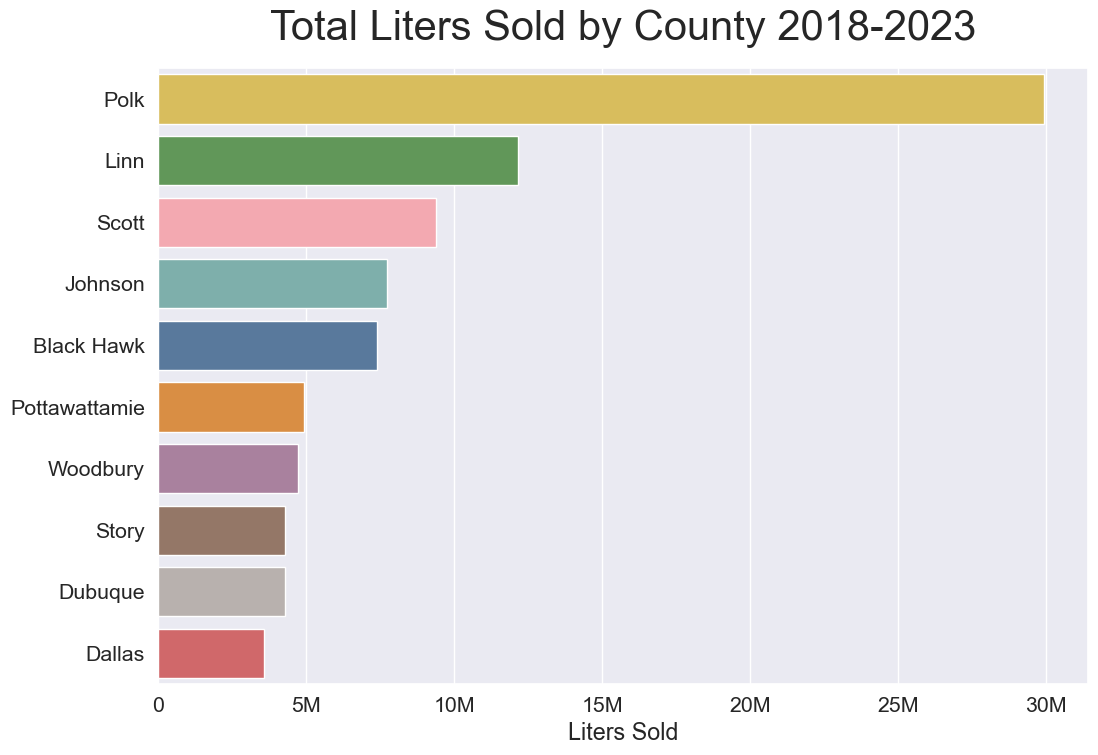

In [13]:
sns.barplot(x = 'liters_sold', y = 'county', data= liters_per_county_df,  palette= county_colors)
ax = plt.gca()
ax.set_title("Total Liters Sold by County 2018-2023" , pad = 20)
ax.set_xlabel("Liters Sold")
ax.set_ylabel(None) 
ax.xaxis.set_major_formatter(tick.FuncFormatter(ticker))
#sns.axes_style("ticks")
sns.set_style("whitegrid")
plt.savefig('liquor_liters_sold.png', transparent= True, bbox_inches='tight', pad_inches=0)

### Polk County purchases much more than other counties. It purchase more than twice the liters of Linn, the next highest consuming county, more than three time the amount of liters as Linn, Scott, Johnson and Black Hawk, and more than six times that purchased by the lower half of counties.  

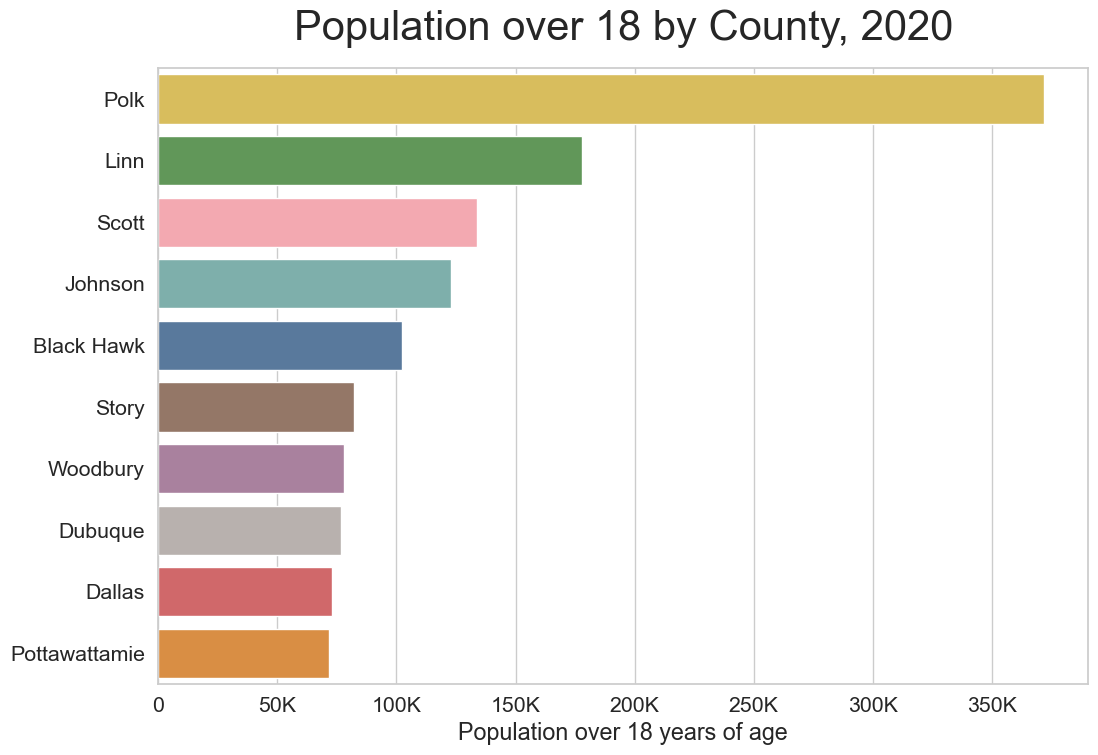

In [14]:
sns.barplot( x = 'population_over_18', y = 'county', data = liters_sold_and_adult_pop_df, palette = county_colors)
ax = plt.gca()
ax.set_title( "Population over 18 by County, 2020" , pad = 20)
ax.set_xlabel( "Population over 18 years of age")
ax.set_ylabel(None)   
#remove plot grey default 

#add lines and ticks
sns.axes_style("ticks")
sns.set_style("whitegrid")
ax.xaxis.set_major_formatter(tick.FuncFormatter(ticker))

plt.savefig('liquor_sales_per_adult.png', transparent=True, bbox_inches='tight', pad_inches=0)

### Population differences by county differ dramatically. Population in Polk, like consumption, is three times higher than the lowest five counties 

### Now we'll account for population differences by visualizing liquor sales per person. This shows the sum of sales in each county divided by the adult population 

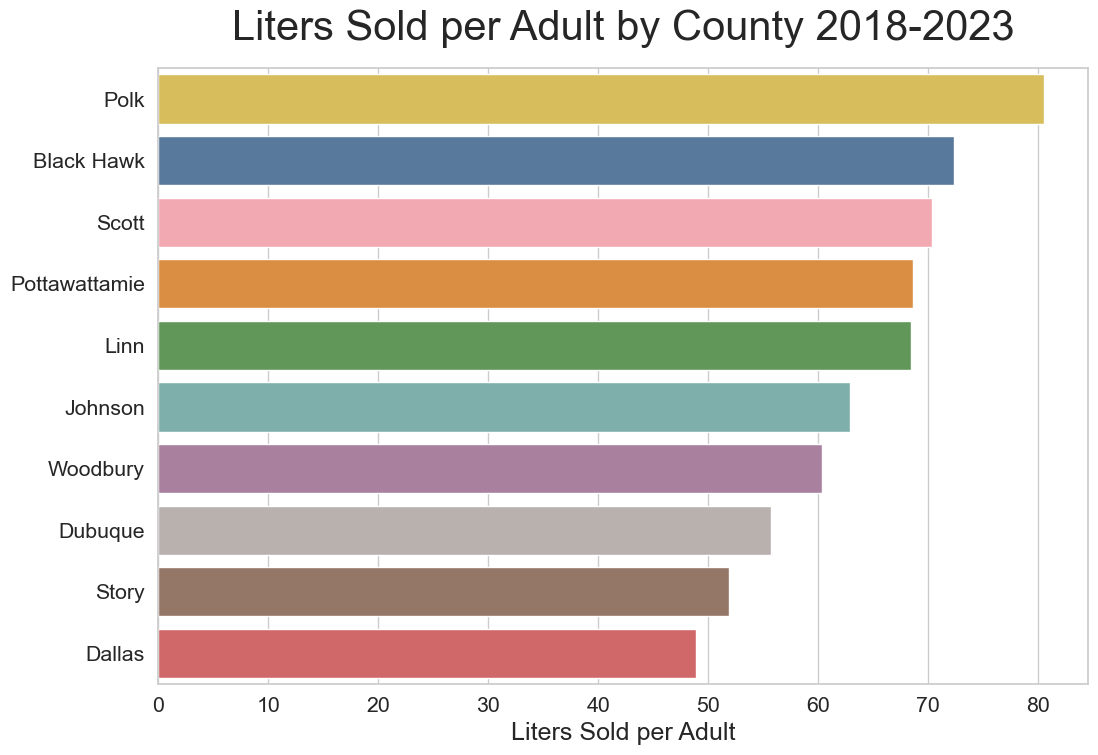

In [15]:
sns.barplot( x = 'liters_sold_per_adult', y = 'county', data = liters_sold_per_adult_df, palette = county_colors)
ax = plt.gca()
ax.set_title( "Liters Sold per Adult by County 2018-2023", pad = 20)
ax.set_xlabel( "Liters Sold per Adult" , size = 18 )
ax.set_ylabel(None)   
#remove plot grey default 

#add lines and ticks
sns.axes_style("ticks")
sns.set_style("whitegrid")

plt.savefig('liquor_sales_per_adult.png', transparent=True, bbox_inches='tight', pad_inches=0)

### Polk still leads in sales, but not nearly as dramatically once population differences are taken into account. 

# Sales over time
### Use Iowa liquor sales data to visualize total sales per county per year over target six year period.

In [16]:
sales_by_county_year_sql_statement = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    county,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  )

SELECT
    sum(volume_sold_liters) AS liters_sold,
    year,
    county
FROM cleaned_source_table
GROUP BY county, year 
ORDER BY year
""" .strip()

sales_by_county_year_df = pd.read_sql_query(sales_by_county_year_sql_statement, engine)
sales_by_county_year_df['county'] = sales_by_county_year_df['county'].str.title()
#sales_by_county_year_df.head()

### We see a bump in 2020-2021 in many counties. Let's calculate and visualize percent change to get a clearer picture. 

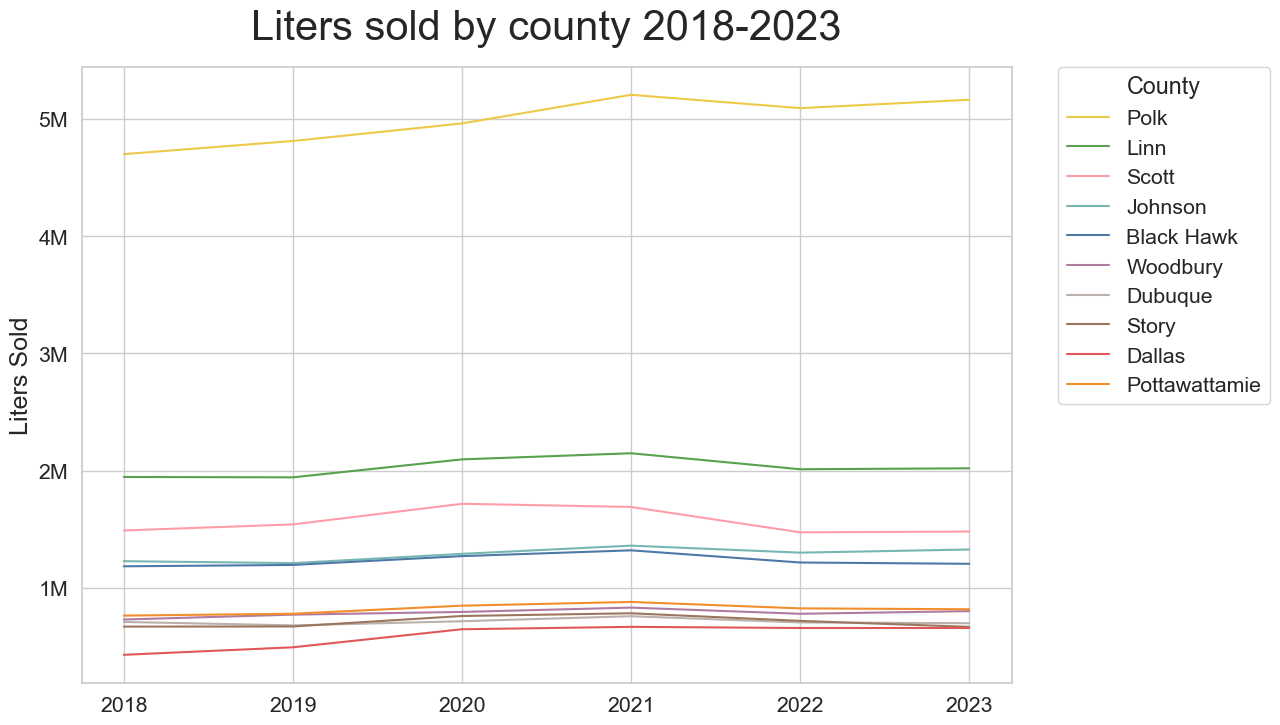

In [17]:
sns.lineplot(data = sales_by_county_year_df, x = 'year', y = 'liters_sold', hue= 'county', palette= county_colors, hue_order = ['Polk', 'Linn', 'Scott', 'Johnson', 'Black Hawk', 'Woodbury', 'Dubuque', 'Story', 'Dallas', 'Pottawattamie'])

ax  = plt.gca()
ax.set_xlabel(None)
ax.set_ylabel( "Liters Sold" , size = 18 )
ax.set_title( "Liters sold by county 2018-2023", pad = 20)
ax.yaxis.set_major_formatter(tick.FuncFormatter(ticker))
plt.legend(title = 'County', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [22]:
# Create a pivot table
pivot_table_df = sales_by_county_year_df.pivot_table(
    index='year',       # Data to be grouped by year
    columns='county',   # Creating separate columns for each county
    values='liters_sold', # Values to sum
    aggfunc='sum'       # Aggregation function
)
county_order = ['Polk', 'Linn', 'Scott', 'Johnson', 'Black Hawk', 'Woodbury', 'Dubuque', 'Story', 'Dallas', 'Pottawattamie']

pivot_table_df = pivot_table_df[county_order]
pivot_table_df

county,Polk,Linn,Scott,Johnson,Black Hawk,Woodbury,Dubuque,Story,Dallas,Pottawattamie
year,,,,,,,,,,
2018,4699225.52,1946474.43,1490333.41,1228588.56,1184783.97,730983.19,710385.99,670742.38,430210.91,764404.84
2019,4811199.30,1943379.02,1541944.96,1211925.90,1196457.18,772659.61,681115.66,671764.06,494232.52,780399.72
2020,4960915.63,2096418.74,1717914.44,1291145.34,1271621.42,795770.68,716519.38,761136.50,648153.86,849129.41
2021,5205018.82,2148693.14,1690814.18,1360950.58,1321043.73,832629.22,759243.53,784310.75,668616.30,880961.61
2022,5091332.66,2012450.73,1474476.94,1301107.05,1217180.04,779923.20,706078.52,719528.03,658762.61,826114.21
2023,5162960.30,2020282.67,1481142.83,1328075.35,1206212.83,802547.54,699567.34,668400.58,658820.70,818508.87


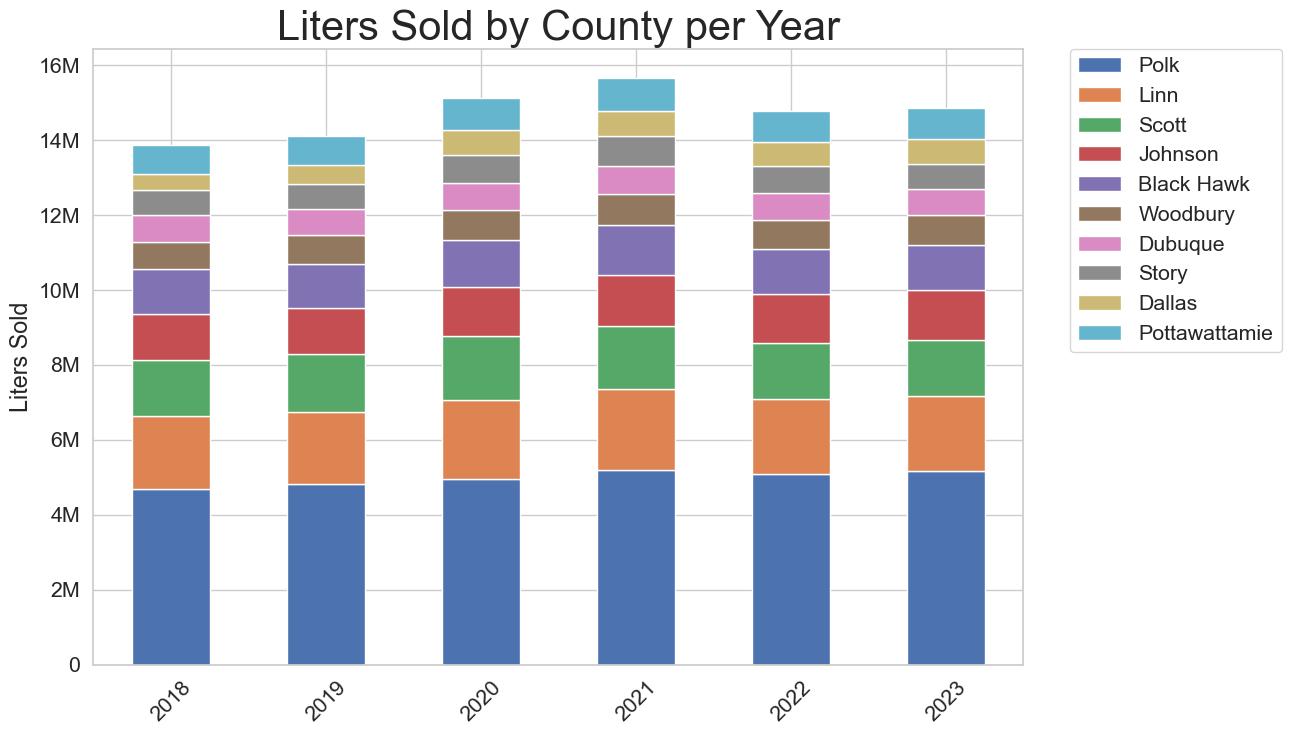

In [23]:
ax = plt.gca
ax = pivot_table_df.plot(kind='bar', stacked=True)

ax.set_xlabel(None)
ax.set_ylabel("Liters Sold")
ax.set_title("Liters Sold by County per Year")
ax.yaxis.set_major_formatter(tick.FuncFormatter(ticker))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

### In the above charts visualizing sales by countyper year, we see an overall increase in sales from 2018 to 2021, and a decrease from 2021 to 2022. Sales were similar in 2022 and 2023. Although there was a dramatic increase forom 2019 to 2021 (possibly due to the COVID19 pandemic) which came down in 2022, there appears to be an gradual increase in sales over the target six year period

### Use Iowa liquor sales data to calculate percent change per year over target four year period. Data from 2017 used to establish percent change for 2018. 

### Percent change calculated as (liters_sold_county - prev_liters_sold_county)/prev_liters_sold_county)*100

In [ ]:
percent_change_county_sql_query = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    county,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2017, 2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  ),

liters_county_sum AS (
  SELECT 
     SUM(volume_sold_liters) as liters_sold_county,
     year,
     county
  FROM cleaned_source_table
  GROUP BY year, county
  ),
  
lag_year AS(
  SELECT
      county,
      year,
      liters_sold_county,
      LAG(liters_sold_county) OVER(PARTITION BY county ORDER BY year) AS prev_liters_sold_county
  FROM liters_county_sum
  ),

percent_change_per_year AS (
  SELECT  
     county,
     year,
     ROUND(((liters_sold_county - prev_liters_sold_county)/prev_liters_sold_county)*100) AS percent_change_year
  FROM lag_year)

  SELECT
        *
  FROM percent_change_per_year
  ORDER BY year, county
  
""" .strip()

percent_change_county_df = pd.read_sql_query(percent_change_county_sql_query, engine)
percent_change_county_df['county'] = percent_change_county_df['county'].str.title()
#percent_change_county_df

### Percent change in liters purchased per county 2018-2023 with 2017 (used to calculate 2018 percent change) removed

In [ ]:
percent_change_county_df['year'] = percent_change_county_df['year'].astype(int)

#filter out 2017. 2017 used to calculate percent change from 2017 to 2018. 
filtered_perc_change_df = percent_change_county_df[percent_change_county_df['year'] != 2017]
#filtered_perc_change_df
#filtered_perc_change_df.to_csv('filtered_perc_change_df.csv', index=False)

### Let's look at the most dramatic year to year changes, where percent change is greater than or equal to 8% in either direction.

In [ ]:
#Filter county/year where percent change is greater than or equal to 8% or less than or equal to -8%
dramatic_perc_change_df = percent_change_county_df[(percent_change_county_df['percent_change_year'] >=8) | (percent_change_county_df['percent_change_year'] <=-8)]
dramatic_perc_change_df

### Dallas county had a 31 percent change from 2019 to 2020. Scott, Story and Dallas each had two dramatic year to year changes

In [ ]:
sns.lineplot(data = percent_change_county_df, x = 'year', y = 'percent_change_year', hue= 'county',  palette= county_colors,  hue_order = ['Polk', 'Linn', 'Scott', 'Johnson', 'Black Hawk', 'Woodbury', 'Dubuque', 'Story', 'Dallas', 'Pottawattamie'])
           
ax= plt.gca()
ax.set_xlabel("Year", size = 16 )
ax.set_ylabel( "Percent Change in Liters Sold" , size = 18 )
ax.set_title( "Percent Change in Liters Sold by County",  pad = 20 )
ax.yaxis.set_major_formatter(tick.PercentFormatter(decimals = 0))
plt.legend(title = 'County', bbox_to_anchor=(1.05, .83), loc='upper left', borderaxespad=0)
plt.show()

### Those dramatic changes per county are evident in the visualization. There appears to be an overall increase in consumption from 2019 to 2020 and then a drop from 2021 to 2022.
### What about overall changes in liquor consumption?

In [ ]:
liters_county_month_sql_query = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    #date,
    store_number,
    county,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year,
    CAST(EXTRACT(MONTH FROM date) AS string) AS month
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN ( 2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, #a.date, 
          a.month, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    #date,
    month,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  ),

liters_county_month AS (
  SELECT 
     SUM(volume_sold_liters) as liters_sold_county,
     #date,
     month,
     year,
     county
  FROM cleaned_source_table
  GROUP BY month, year, county
  )

  SELECT
        *
  FROM liters_county_month
  ORDER BY month, year, county

""" .strip()

liters_county_month_df = pd.read_sql_query(liters_county_month_sql_query, engine)
liters_county_month_df['county'] = liters_county_month_df['county'].str.title()
liters_county_month_df

In [ ]:
#liters_county_month_df.info()

In [ ]:
liters_county_month_df['year'] = liters_county_month_df['year'].astype(str)
liters_county_month_df['month'] = liters_county_month_df['month'].astype(str)

# Combine 'year' and 'month' into a single 'date' column formatted as 'YYYY-MM'
liters_county_month_df['date'] = pd.to_datetime(liters_county_month_df['year'] + '-' + liters_county_month_df['month'])
liters_county_month_df.info()
liters_county_month_df.to_csv('liters_county_month_df.csv', index = False)
liters_county_month_df

In [ ]:
sns.lineplot(data = liters_county_month_df, x = 'date', y = 'liters_sold_county', hue= 'county', palette= county_colors, hue_order = ['Polk', 'Linn', 'Scott', 'Johnson', 'Black Hawk', 'Woodbury', 'Dubuque', 'Story', 'Dallas', 'Pottawattamie'])
   
ax  = plt.gca()
ax.set_xlabel(None)
ax.set_ylabel( "Liters Sold" , size = 18 )
ax.set_title( "Liters sold by county per month 2018-2023", pad = 20 )
ax.yaxis.set_major_formatter(tick.FuncFormatter(ticker))
plt.legend(title = 'County', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### We see some seasonal patterns, the most notable being a jump in sales just before the new year and a drop in January. This may be due to the fact that this retail sales. Stores likely stock up for December and new year celebrations and pause ordering afterward. 